In [1]:
## lrasmy@Zhilab last revised August 1 2021 ##
##############################################

In [8]:
### Mount your google drive ###
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Required packages

Make sure that you are using a GPU Runtime


In [9]:
### install required packages
! pip install lifelines --user
! pip install pip install 'ray[default]'
! pip install 'ray[tune]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/li

In [3]:
import os
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import time
from tqdm import tqdm

import sklearn.metrics as m
from sklearn.metrics import roc_auc_score
from termcolor import colored


import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
#if use_cuda: torch.cuda.set_device(7)




#### Please Note: if any error message displayed or you installed fresh packages, please make sure you run the following pytorch_ehr import cell **twice**

---



---



In [11]:
from importlib import reload

### import pytorch ehr files
try:
  import sys
  sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
  import pytorch_ehr
  import pytorch_ehr.models as model 
  from pytorch_ehr.EHRDataloader import EHRdataloader
  from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
  import pytorch_ehr.utils_final as ut 
  from pytorch_ehr.EHREmb import EHREmbeddings
except:
  exit()
  print('Notebook restarted after package installation')

Notebook restarted after package installation


In [1]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
import pytorch_ehr
import pytorch_ehr.models as model 
from pytorch_ehr.EHRDataloader import EHRdataloader
from pytorch_ehr.EHRDataloader import EHRdataFromLoadedPickles as EHRDataset
import pytorch_ehr.utils_final as ut 
from pytorch_ehr.EHREmb import EHREmbeddings

### load preprocessed data

In [4]:
input_dir='/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Data_Prep/data/processed_data/'
data_prefix='/dhf_easy_dmd_v1'
output_dir = '/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/Model_output/'
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

In [5]:
### Load the preprocessed data

train_sl= pickle.load(open(input_dir+data_prefix+'.combined.train', 'rb'),encoding='bytes')
test_sl= pickle.load(open(input_dir+data_prefix+'.combined.test', 'rb'), encoding='bytes')
valid_sl= pickle.load(open(input_dir+data_prefix+'.combined.valid', 'rb'), encoding='bytes')
# types dictionary
types_d=pickle.load(open(input_dir+data_prefix+'.types', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))
input_size_l=[max(types_d_rev.keys())+1]
print (len(train_sl),len(valid_sl),len(test_sl))
print(input_size_l)

8485 1211 2423
[432]


In [7]:
test_sl2= pickle.load(open(input_dir+'/dhf_hard_dmd_v1'+'.combined.test', 'rb'), encoding='bytes')
print (len(test_sl2))

2352


In [8]:
def load_mbs_var_list(sets_list,packpadmode,task,bs=128,half=True):
    if task: multiLbl=True
    mb_lists=[]
    for dset in sets_list:
        print (' creating the list of minibatches')
        dataset = EHRDataset(dset,sort= True, model='RNN')
        data_mbs = list(tqdm(EHRdataloader(dataset, batch_size = bs, packPadMode = packpadmode,multilbl=multiLbl)))
        mb_lists.append(data_mbs)
    return mb_lists


In [9]:
[train_mbs,valid_mbs,test_mbs]=load_mbs_var_list([train_sl,valid_sl,test_sl],packpadmode=True,task='mort',bs=256)

 creating the list of minibatches
multilabel data processing


100%|██████████| 34/34 [00:55<00:00,  1.65s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 5/5 [00:07<00:00,  1.44s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 10/10 [00:17<00:00,  1.70s/it]


### Model Training

#### Binary Classification

In [44]:
#### Binary classification Model
ehr_model=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=32, n_layers=1,cell_type='GRU',bii=True ,time=True, packPadMode=True, surv=False, cls_dim=1)
if use_cuda:ehr_model.cuda()
train_auc_allep,valid_auc_allep,test_auc_allep,RNN_f_label,RNN_f_score=ut.run_dl_model(ehr_model,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_t1.pth',output_dir+'ACM_BCB_t1.st',wmodel='RNN',packpadmode=True,task='mort',opt='Adamax', lr=0.1)


weights :  None
Epoch:  0  Train_auc : 0.8458974125689304  , Valid_auc :  0.8423478112175102  Avg Loss:  0.7327494462331137  , Train Time : 0m 0s
 & Test_auc s :  [0.8475522169558348]
Eval Time : 0m 0s

 Confusion matrix yellow
[[1391  117]
 [ 367  548]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      1508
         1.0       0.82      0.60      0.69       915

    accuracy                           0.80      2423
   macro avg       0.81      0.76      0.77      2423
weighted avg       0.80      0.80      0.79      2423

Epoch:  1  Train_auc : 0.8894564254090036  , Valid_auc :  0.8849549703602372  Avg Loss:  0.42123919179042174  , Train Time : 0m 0s
 & Test_auc s :  [0.8875657694481889]
Eval Time : 0m 0s

 Confusion matrix yellow
[[1374  134]
 [ 189  726]]

 Classification Report:               precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1508
         1.0       

#### Survival

In [35]:
###Survival Model
ehr_model_s=model.EHR_RNN(input_size_l,embed_dim=64, hidden_size=64, n_layers=1,cell_type='GRU',bii=True ,time=True, packPadMode=True, surv=True)
if use_cuda:ehr_model_s.cuda()

train_auc_allep_S,valid_auc_allep_S,test_auc_allep_S,RNN_f_label_S,RNN_f_score_S=ut.run_dl_model_surv(ehr_model_s,train_mbs,valid_mbs,[test_mbs],output_dir+'ACM_BCB_s1.pth',output_dir+'ACM_BCB_s1.st',wmodel='RNN',packpadmode=True,task='mort_surv',patience=5)


Epoch:  0  Train_cindex : 0.634618279052645  , Valid_cindex :  0.6247567221204745  Avg Loss:  4.127988521258036  , Train Time : 0m 0s
 & Test_auc s :  [0.6270119780195845]
Eval Time : 0m 0s
Epoch:  1  Train_cindex : 0.6523464767424025  , Valid_cindex :  0.631874542733224  Avg Loss:  3.9644513845443723  , Train Time : 0m 0s
 & Test_auc s :  [0.6369310953180792]
Eval Time : 0m 0s
Epoch:  2  Train_cindex : 0.6623572338032158  , Valid_cindex :  0.6358626263012677  Avg Loss:  3.8935880343119305  , Train Time : 0m 0s
 & Test_auc s :  [0.6417945633192529]
Eval Time : 0m 0s
Epoch:  3  Train_cindex : 0.6772482170010331  , Valid_cindex :  0.6658401993085409  Avg Loss:  3.8871916532516475  , Train Time : 0m 0s
 & Test_auc s :  [0.6637877908503766]
Eval Time : 0m 0s
Epoch:  4  Train_cindex : 0.677634995785392  , Valid_cindex :  0.654865796684248  Avg Loss:  3.855603528022766  , Train Time : 0m 0s
Epoch:  5  Train_cindex : 0.7009647236232494  , Valid_cindex :  0.6793633411915475  Avg Loss:  3.81611

### Hyperparameter Tunninig

5 years ago, Bayesian optimization was the SOTA of hyperparemeters search, an example resource is Botorch 

Nowadays there many new packages for hyperparameter search exist, some popular examples include RayTune and Optuna 

Actually you can even combine both where you can get the benefit of the best computational resources utilization from ray tune and the optuna search algorithm.
More examples are on:

 Pytorch Raytune Tutorial: https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html?highlight=transformer 

Using Optuna algorithm in Raytune:
https://docs.ray.io/en/master/tune/api_docs/suggestion.html#tune-optuna

Optuna code examples (select pytorch): https://optuna.org/#code_examples

Optuna tutorial on multi-objective optimization: https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/002_multi_objective.html#sphx-glr-tutorial-20-recipes-002-multi-objective-py


####### here I'll only show a very shallow hand written example on the main concept for the sake of time


In [12]:
def run_dl_model_hps(config, input_size_1=[27362],epochs=100, task='mort', w_model='RNN', packpadmode=True, patience=10):
    ### for raytune, you need to limit your input to the config or use tune.with_parameters 
    ### for optuna, your input will be the trial
    ### Further examples can be found above

    sys.path.insert(0,"/content/drive/MyDrive/pytorch_ehr/Pytorch_EHR_Tutorial/Model_Training/")
    import pytorch_ehr
    from pytorch_ehr import models as model 
    from pytorch_ehr import utils_final as ut

    l2 = config['l2']
    lr = config['lr']
    #lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)  #### this is just an example in case you use optuna
    eps = config['eps']    
    try:
      opt = config['opt']
    except: 
      opt='Adamax'
      print('optimizer reset to Adamax') 
    try:
      embed_dim = config['embed_dim']
      hidden_size = config['hidden_size']
    except:
      embed_dim = 2**config['embed_dim_exp']
      hidden_size = 2**config['hidden_size_exp']
      print("embed_dim: ", embed_dim , " hidden_size" , hidden_size )

    ehr_model = model.EHR_RNN(input_size_1, embed_dim=embed_dim, hidden_size=hidden_size, n_layers=1, cell_type='GRU', bii=False , time=True)
    if use_cuda: ehr_model = ehr_model.cuda()

    if opt== 'Adadelta':
        #lr=1
        optimizer = optim.Adadelta(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ## rho=0.9
    elif opt== 'Adagrad':
        optimizer = optim.Adagrad(ehr_model.parameters(), lr=lr, weight_decay=l2) ##lr_decay no eps
    elif opt== 'Adam':
        optimizer = optim.Adam(ehr_model.parameters(), lr=lr, weight_decay=l2,eps=eps ) ## Beta defaults (0.9, 0.999), amsgrad (false)
    elif opt== 'Adamax':
        optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps) ### Beta defaults (0.9, 0.999)
    elif opt== 'RMSprop':
        optimizer = optim.RMSprop(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)                
    elif opt== 'ASGD':
        optimizer = optim.ASGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    elif opt== 'SGD':
        optimizer = optim.SGD(ehr_model.parameters(), lr=lr, weight_decay=l2 ) ### other parameters
    

    ##Training epochs
    bestValidAuc = 0.0
    bestValidEpoch = 0

    ### epochs loop
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = ut.trainbatches_outcomes(train_mbs, model= ehr_model, task=task, optimizer = optimizer,loss_fn = nn.BCELoss())
        avg_loss = np.mean(train_loss)
        train_time = ut.timeSince(start)
        eval_start = time.time()
        #Train_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, train_mbs, task=task, which_model = w_model)
        valid_auc, y_real, y_hat  = ut.calculate_auc_outcomes(ehr_model, valid_mbs, task=task, which_model = w_model)
        #print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) )
        if valid_auc > bestValidAuc: 
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bavg_loss= avg_loss
        if ep - bestValidEpoch >patience: break
    #tune.report(accuracy=bestValidAuc)
    return bestValidAuc,bavg_loss,bestValidEpoch

In [13]:
def loguniform (lower, upper):
  logmin = np.log(lower) / np.log(10)
  logmax = np.log(upper) / np.log(10)
  items = 10**(np.random.uniform(logmin, logmax, size=1))
  return (items.round(7)[0])

results_ft=[]
for opt in ['Adamax','Adagrad']:
  for run in range(2):
    config = {"l2": loguniform(1e-5, 1e-2),
              "lr": loguniform(1e-3, 1e-1),
              "opt": opt,
              "eps": loguniform(1e-6, 1e-2),
              "embed_dim_exp": np.random.randint(5, 8),
              "hidden_size_exp": np.random.randint(5, 9)}
    config['best_valid_auc'], config['avg_loss'], config['best_epoch']=run_dl_model_hps(config)
    results_ft.append(config)

pd.DataFrame(results_ft)

embed_dim:  128  hidden_size 32
embed_dim:  128  hidden_size 256
embed_dim:  32  hidden_size 128
embed_dim:  32  hidden_size 32


,l2,lr,opt,eps,embed_dim_exp,hidden_size_exp,best_valid_auc,avg_loss,best_epoch
0,0.000031,0.083908,Adamax,0.002416,7,5,0.942006,0.181248,25
1,0.000064,0.089206,Adamax,0.000227,7,8,0.941627,0.244813,12
2,0.002665,0.001120,Adagrad,0.000966,5,7,0.845431,0.440106,99
3,0.001679,0.015227,Adagrad,0.000007,5,5,0.914210,0.271702,47


In [ ]:
#### example code if you need to run raytune
#from ray import tune
#
#config = {"l2": tune.loguniform(1e-5, 1e-2),
#          "lr": tune.loguniform(1e-3, 1e-1),
#          "opt": tune.grid_search(['Adamax','Adagrad']),
#          "eps": tune.loguniform(1e-6, 1e-2),
#          "embed_dim": tune.sample_from(lambda _: 2 ** np.random.randint(5, 8)),
#          "hidden_size": tune.sample_from(lambda _: 2 ** np.random.randint(5, 9))}
#
#result=tune.run(run_dl_model_hps,config=config)

### Model Evaluation


#### Binary Classification Models

In [45]:
### to load a trained mode
best_model_bc = torch.load(output_dir+'ACM_BCB_t1.pth')
if use_cuda:best_model_bc.cuda()

### create a minibatch list for my new test set
[valid_mbs,test2_mbs]=load_mbs_var_list([valid_sl,test_sl2],packpadmode=True,task='mort',bs=256)

### to get the predictions
t2_labels, t2_scores = ut.get_preds( test2_mbs , best_model_bc )
t2_metrics_df, t2_metrics_list = ut.cl_metrics_bc('Test2',t2_labels, t2_scores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
t2_metrics_df

 creating the list of minibatches
multilabel data processing


100%|██████████| 5/5 [00:07<00:00,  1.54s/it]


 creating the list of minibatches
multilabel data processing


100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test2,0.065269,0.891656,0.830515,0.022052,0.95174,0.370294,0.839286,0.748306,0.867565,0.803534,0.82204


In [46]:
vlabels, vscores = ut.get_preds( valid_mbs , best_model_bc )
vmetrics_df, vmetrics_list = ut.cl_metrics_bc('valid',vlabels, vscores) ### As I don't specify the threshold on the ths option, it will calculate the best threshold
vmetrics_df

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,valid,0.232937,0.940327,0.941449,0.098502,0.95,0.541724,0.888522,0.869379,0.845833,0.857445,0.916553


In [55]:
cohorts_preds=[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze()),('Test2',t2_labels, t2_scores)]
#,('valid',vlabels, vscores)

In [48]:
df_metrics = ut.cl_metrics_m(cohorts_preds,bth=0.15)
df_metrics

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity
0,Test 1,0.15,0.936787,0.935171,0.095433,0.95082,0.537798,0.782501,0.654459,0.898361,0.757255,0.712202
1,valid,0.15,0.940327,0.941449,0.098502,0.95000,0.541724,0.804294,0.691943,0.912500,0.787062,0.733242
2,Test2,0.15,0.891656,0.830515,0.022052,0.95174,0.370294,0.830357,0.755187,0.817059,0.784906,0.838467


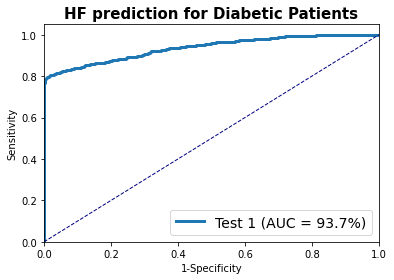

In [49]:
ut.plot_roc_curve_combined_m("HF prediction for Diabetic Patients",[('Test 1', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())])

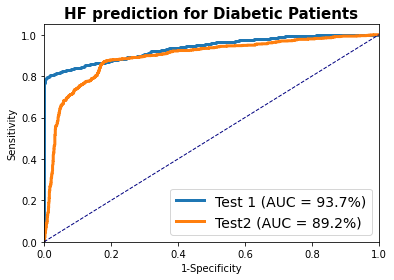

In [56]:
ut.plot_roc_curve_combined_m("HF prediction for Diabetic Patients",cohorts_preds)

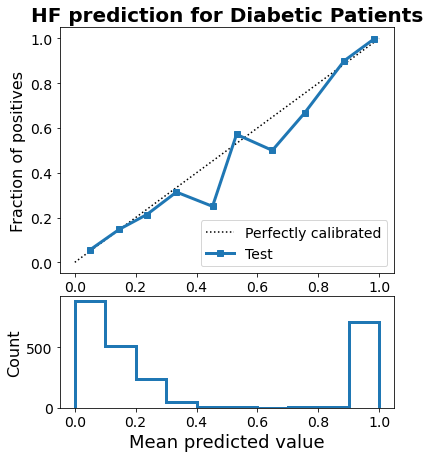

In [51]:
ut.plot_calibration_curve_m("HF prediction for Diabetic Patients",1,[('Test', np.array(RNN_f_label).squeeze() , np.array(RNN_f_score).squeeze())],n_bins=10)

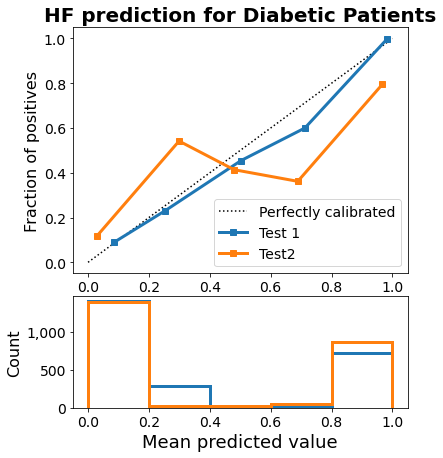

In [57]:
ut.plot_calibration_curve_m("HF prediction for Diabetic Patients",1,cohorts_preds,n_bins=5)

### Survival Model


In [36]:
### to load a trained model
best_model_surv = torch.load(output_dir+'ACM_BCB_s1.pth')
if use_cuda:best_model_surv.cuda()

### to get the predictions
t2_labels_s, t2_scores_s = ut.get_preds( test2_mbs , best_model_surv , surv=True )


In [37]:
#reload(ut)
df_ts2_pred=ut.convert_preds_df(t2_labels_s, t2_scores_s,surv=True)
df_ts2_pred

,Label,TTE,pred_nloghHF
0,1.0,2988.0,-2.242817
1,0.0,16416.0,1.080449
2,0.0,6685.0,-1.959051
3,0.0,5796.0,-4.456643
4,0.0,8771.0,0.113013
...,...,...,...
2347,1.0,19295.0,-4.550102
2348,0.0,3557.0,-2.686971
2349,1.0,18418.0,-2.282347
2350,0.0,14098.0,-6.230288


In [38]:
vlabels_s, vscores_s = ut.get_preds( valid_mbs , best_model_surv , surv=True )
valid_ref= ut.create_ref_percentile(vlabels_s, vscores_s )
valid_ref

,percentile,pred_nloghHF
0,0.00,-5.11
1,0.01,-4.28
2,0.02,-3.88
3,0.03,-3.52
4,0.04,-3.20
...,...,...
96,0.96,3.43
97,0.97,3.79
98,0.98,4.48
99,0.99,5.62


In [39]:
df_ts2_pred_perc=ut.assign_perc_based_on_reference(df_ts2_pred,valid_ref)
df_ts2_pred_perc

,Label,TTE,pred_nloghHF,percentile_from_ref,pred_max
0,1.0,2988.0,-2.242817,0.10,-2.20
1,0.0,16416.0,1.080449,0.65,1.10
2,0.0,6685.0,-1.959051,0.13,-1.86
3,0.0,5796.0,-4.456643,0.01,-4.28
4,0.0,8771.0,0.113013,0.45,0.16
...,...,...,...,...,...
2347,1.0,19295.0,-4.550102,0.01,-4.28
2348,0.0,3557.0,-2.686971,0.07,-2.58
2349,1.0,18418.0,-2.282347,0.10,-2.20
2350,0.0,14098.0,-6.230288,0.00,-5.11


In [40]:
### We can do the following:
df_vs_pred = ut.get_preds_asdf( valid_mbs , best_model_surv , surv=True )
df_vs_pred['cohort']='valid'
df_ts_pred = ut.get_preds_asdf( test_mbs , best_model_surv , surv=True )
df_ts_pred['cohort']='test'
df_ts2_pred['cohort']='test2'
df_s_pred= pd.concat([df_ts_pred,df_vs_pred,df_ts2_pred])
df_s_pred_perc=ut.assign_perc_based_on_reference(df_s_pred,valid_ref)

#### and plot curves as shown later

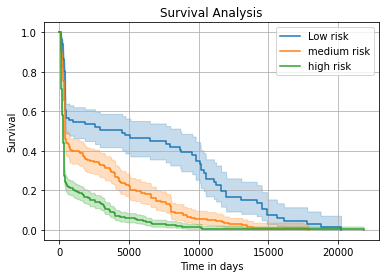

          removed  observed  censored  entrance  at_risk  survival prob
event_at                                                               
93.0           11         9         2         0      801       0.970365
134.0           7         5         2         0      466       0.763880
146.0           1         1         0         0      432       0.733682
168.0          11         4         7         0      390       0.681391
206.0           3         2         1         0      325       0.609666
226.0           2         2         0         0      304       0.584773
251.0           6         4         2         0      273       0.533570
269.0           1         1         0         0      250       0.507405
287.0           1         0         1         0      232       0.476753
291.0           2         2         0         0      226       0.464351
305.0           1         1         0         0      210       0.437259
346.0           1         1         0         0      142       0

In [41]:
## Model initiation
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
subcohort=df_s_pred_perc[df_s_pred_perc['cohort']=='test']
for per_range in [['Low risk',0,0.3],['medium risk',0.3,0.6],['high risk',0.6,1]]:
    [subset,from_p,to_p]=per_range
    sub_per=subcohort[subcohort['percentile_from_ref'].between(from_p,to_p,inclusive='left')]
    t = sub_per['TTE']
    l = sub_per['Label']
    kmf.fit(t,l, label=subset)
    kmf.plot(title='Survival Analysis', ax=ax)#, at_risk_counts =True)
    plt.ylabel('Survival')
    plt.xlabel('Time in days')
    plt.grid(True)
plt.show()

table = kmf.event_table
table['survival prob'] = kmf.survival_function_
print(table.sample(n=20).sort_values(by='event_at'))

In [42]:
#### calculate clinically relevant metrics
cohorts_preds_surv=[]
for cohort in df_s_pred_perc['cohort'].unique():
    subset_surv_pred=df_s_pred_perc[df_s_pred_perc['cohort']== cohort]
    for t in [180,365,730,1096,2200]:
        true_label=((subset_surv_pred['Label']==1)&(subset_surv_pred['TTE']<=t)).astype(float)
        cohorts_preds_surv.append([cohort+'_t'+str(t),true_label,subset_surv_pred['percentile_from_ref']])

df_metrics_surv = ut.cl_metrics_m(cohorts_preds_surv,bth=0.15)
df_metrics_surv[['dataset', 'day_window']]= df_metrics_surv['Cohort'].str.split('_t', expand=True)
df_metrics_surv['day_window']=df_metrics_surv['day_window'].astype(int)
df_metrics_surv

,Cohort,best_ths_given,AUROC,AUPRC,ths_95_sens,sens95,spec95,accuracy,precision,sensitivity_recall,f1-score,specificity,dataset,day_window
0,test_t180,0.15,0.743800,0.288096,0.24,0.950311,0.258448,0.268262,0.151704,0.981366,0.262786,0.158972,test,180
1,test_t365,0.15,0.742136,0.480782,0.18,0.952066,0.207371,0.369377,0.278445,0.958678,0.431548,0.173267,test,365
2,test_t730,0.15,0.696839,0.490792,0.13,0.954483,0.155477,0.408172,0.329813,0.947586,0.489316,0.177856,test,730
3,test_t1096,0.15,0.697423,0.495427,0.13,0.955102,0.156398,0.412299,0.334614,0.948299,0.494677,0.178910,test,1096
4,test_t2200,0.15,0.700512,0.509319,0.15,0.950197,0.181928,0.423855,0.348056,0.950197,0.509487,0.181928,test,2200
5,valid_t180,0.15,0.742507,0.306162,0.26,0.950000,0.284491,0.270851,0.151398,0.981250,0.262322,0.162702,valid,180
6,valid_t365,0.15,0.756531,0.504838,0.24,0.950980,0.295028,0.386457,0.289296,0.980392,0.446761,0.185635,valid,365
7,valid_t730,0.15,0.719305,0.519217,0.18,0.951220,0.228029,0.425268,0.342334,0.962060,0.504979,0.190024,valid,730
8,valid_t1096,0.15,0.718652,0.521708,0.18,0.951872,0.229391,0.429397,0.347155,0.962567,0.510276,0.191159,valid,1096
9,valid_t2200,0.15,0.724935,0.537046,0.19,0.951282,0.247259,0.442609,0.362584,0.964103,0.526980,0.194884,valid,2200


dataset
test     AxesSubplot(0.125,0.125;0.775x0.755)
test2    AxesSubplot(0.125,0.125;0.775x0.755)
valid    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

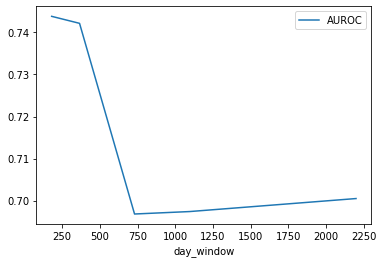

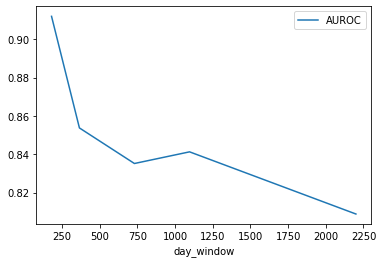

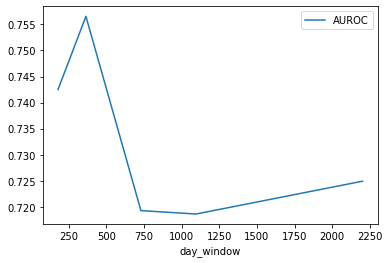

In [43]:
df_metrics_surv.groupby('dataset')[['day_window','AUROC']].plot(x='day_window')